### Импортируем весь инструментарий

In [1]:
import numpy as np
import pandas as pd

import nltk
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns

import gensim

# Способ визуализации "популярных" слов в датасете
from wordcloud import WordCloud
from wordcloud import WordCloud, STOPWORDS

from sklearn.decomposition import PCA
from gensim.models import Word2Vec, FastText
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV

import string

### Загружаем датасет

In [2]:
dataset_url = "https://raw.githubusercontent.com/danilkladnitsky/nlp-tasks/hw_2/hw_2/archive.zip"

email_dataset = pd.read_csv(
    dataset_url, encoding="utf-8", names=['email', 'label'])
email_dataset.head()

,email,label
0,email,label
1,date wed NUMBER aug NUMBER NUMBER NUMBER NUMB...,0
2,martin a posted tassos papadopoulos the greek ...,0
3,man threatens explosion in moscow thursday aug...,0
4,klez the virus that won t die already the most...,0


### Инициализируем utils-функции 

In [3]:
COLOR_MAP = "Pastel1"
BG_COLOR = "#000000"
WORD_CLOUD_SIZE = [2000, 2000]
RANDOM_STATE = 2023


def make_wordcloud(dataset, stopwords):
    word_cloud = WordCloud(
        stopwords=stopwords,
        width=WORD_CLOUD_SIZE[0],
        height=WORD_CLOUD_SIZE[1],
        random_state=RANDOM_STATE,
        background_color=BG_COLOR,
        colormap=COLOR_MAP,
        collocations=False,
    ).generate(dataset)

    return word_cloud


def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text


def remove_non_english_characters(text):
    return text.replace(r'[^\x00-\x7f]', '')


def remove_stop_words(sentence):
    words = sentence.split(" ")
    res = ''

    for word in words:
        if word not in STOPWORDS:
            res += word + " "

    return res

### Предобрабатываем данные

label
0    2445
1     427
Name: count, dtype: int64
                                                  email label  \
0      date wed number aug number number number numb...     0   
1     martin posted tassos papadopoulos greek sculpt...     0   
2     man threatens explosion moscow thursday august...     0   
3     klez virus won t die already prolific virus kl...     0   
4      adding cream spaghetti carbonara effect pasta...     0   
...                                                 ...   ...   
2867   abc s good morning america ranks number chris...     1   
2868   hyperlink hyperlink hyperlink let mortgage le...     1   
2869   thank shopping us gifts occasions free gift n...     1   
2870   famous ebay marketing e course learn sell com...     1   
2871   hello chinese traditional 子 件 number世 o最有效的宣 ...     1   

                                       normalized_email  
0     [date, wed, number, aug, number, number, numbe...  
1     [martin, posted, tassos, papadopoulos, greek,

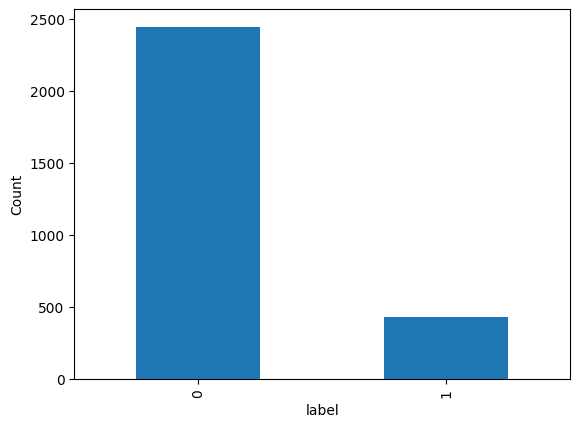

In [4]:
# Убираем дубликаты, первую строку
email_dataset.drop_duplicates(inplace=True)
email_dataset.drop(index=email_dataset.index[0], axis=0, inplace=True)
email_dataset['email'].replace('', np.nan, inplace=True)
email_dataset.dropna(subset=['email'], inplace=True)

email_dataset.reset_index(drop=True, inplace=True)

# Переводим в нижний регистр, разбираемся с пунктуацией
email_dataset['email'] = email_dataset['email'].str.lower()
email_dataset['email'] = email_dataset['email'].apply(remove_punctuations)
email_dataset['email'] = email_dataset['email'].apply(remove_stop_words)

email_dataset['normalized_email'] = email_dataset['email'].apply(
    lambda x: gensim.utils.simple_preprocess(x))

count_data = email_dataset["label"].value_counts()
print(count_data)

plt.xlabel("Label")
plt.ylabel("Count")

count_data.plot.bar()
print(email_dataset)
plt.show()

### Визуализируем датасет

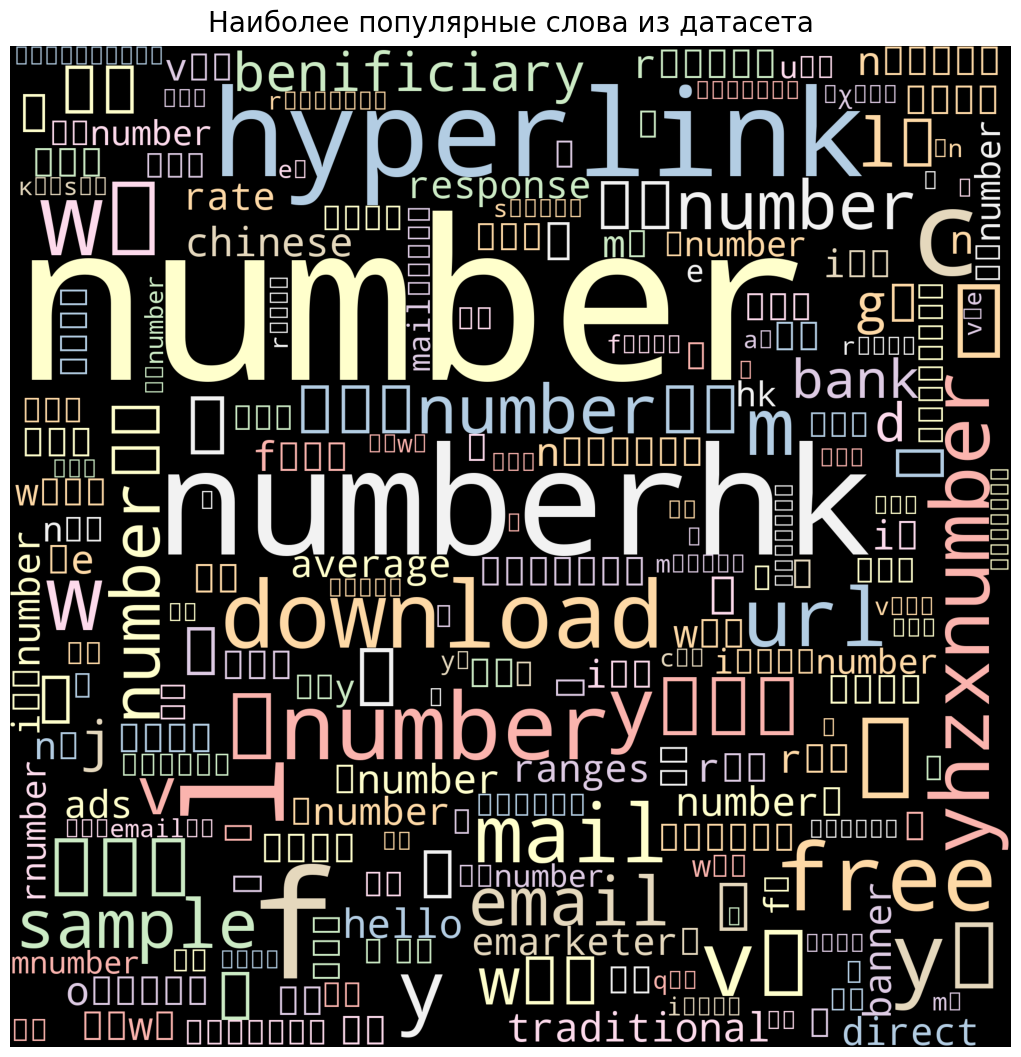

In [5]:
plain_emails = []
for i in range(len(email_dataset['email'])):
    plain_emails = email_dataset['email'][i]

plain_emails_cloud = make_wordcloud(plain_emails, STOPWORDS)

plt.figure(figsize=(13, 13))
plt.title("Наиболее популярные слова из датасета", fontdict={'size': 20, 'color': 'black',
                                                             'verticalalignment': 'bottom'})
plt.imshow(plain_emails_cloud)
plt.axis("off")
plt.show()

In [9]:
email_corpus = []

for line in email_dataset['email']:
    words = line.split(" ")
    email_corpus.append(words)

model = Word2Vec(email_corpus, min_count=1, vector_size=24)

### Визуализируем векторы от Word2Vec

In [8]:
# WORDS_INDEX_LIST = model.wv.key_to_index

# X = model.wv[WORDS_INDEX_LIST]
# pca = PCA(n_components=2)
# result = pca.fit_transform(X)
# pca_df = pd.DataFrame(result, columns=['x', 'y'])

# N = 1000000
# words = list(WORDS_INDEX_LIST)
# fig = go.Figure(data=go.Scattergl(
#     x=pca_df['x'],
#     y=pca_df['y'],
#     mode='markers',
#     marker=dict(
#         color=np.random.randn(N),
#         colorscale='Viridis',
#         line_width=1
#     ),
#     text=words,
#     textposition="bottom center"
# ))

# fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

### Сплиттим данные

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    email_corpus,
    email_dataset['label'],
    test_size=0.2,
    random_state=RANDOM_STATE
)

w2v_model = gensim.models.Word2Vec(
    X_train,
    vector_size=100,
    window=10,
    min_count=3
)


def vectorize(sentence):
    words_vecs = [w2v_model.wv[word]
                  for word in sentence if word in w2v_model.wv]

    if len(words_vecs) == 0:
        return np.zeros(100)

    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0)

### Word2Vec x LogisticRegression

In [11]:
x_train_logistic = np.array([vectorize(sentence) for sentence in X_train])
x_test_logistic = np.array([vectorize(sentence) for sentence in X_test])

clf = LogisticRegression()
clf.fit(x_train_logistic, y_train)

y_pred = clf.predict(x_test_logistic)

print('Accuracy:', accuracy_score(y_test, y_pred))

Accuracy: 0.9843478260869565


### Intrinsic scoring

In [12]:
simlex_url = "https://raw.githubusercontent.com/danilkladnitsky/nlp-tasks/hw_3/hw_3/simlex.txt"
simlex = pd.read_csv(simlex_url, encoding="utf-8", delimiter="\t")

simplex_words = simlex['word1'].to_list()

words = list(w for w in w2v_model.wv.index_to_key)

for word in list(words)[:50]:
    if word in simplex_words:
        print("simlex word: " + word)

        simlex_analogues = simlex.loc[simlex['word1'] == word].word2.to_list()

        for i in w2v_model.wv.most_similar(positive=[word], topn=3):
            # слово + коэффициент косинусной близости
            print("word2vec variant: " + i[0], i[1])

        for simlex_word in simlex_analogues:
            print("-> simlex analogues: " + simlex_word)

simlex word: people
word2vec variant: rarely 0.968822181224823
word2vec variant: pony 0.9585837721824646
word2vec variant: recession 0.9548777937889099
-> simlex analogues: party
-> simlex analogues: cent
-> simlex analogues: gun
-> simlex analogues: balloon
simlex word: new
word2vec variant: old 0.8534267544746399
word2vec variant: cell 0.8108835220336914
word2vec variant: tired 0.7948836088180542
-> simlex analogues: fresh
-> simlex analogues: ancient
simlex word: make
word2vec variant: exceedingly 0.9371955394744873
word2vec variant: need 0.9363825917243958
word2vec variant: people 0.9320988059043884
-> simlex analogues: construct
-> simlex analogues: earn
-> simlex analogues: become
simlex word: date
word2vec variant: gmt 0.984833836555481
word2vec variant: austin 0.9766618013381958
word2vec variant: tx 0.973841667175293
-> simlex analogues: calendar
simlex word: world
word2vec variant: agreeable 0.9132981300354004
word2vec variant: trade 0.8600707650184631
word2vec variant: edward

### FastText and LogisticRegression

In [19]:
fasttext_model = FastText(email_corpus, vector_size=128,
                          window=5, min_count=3, workers=4, epochs=10, seed=42)
ftm = fasttext_model.wv

In [14]:
print(len(ftm.index_to_key), ftm.vector_size)

13181 128


In [15]:
ftm['people']

array([-0.4413912 , -0.45842272, -0.45860276, -0.9155401 , -0.32589105,
        0.231961  , -1.4506159 , -0.66647124, -0.3532122 , -0.70457494,
        1.2036783 ,  0.39046073,  1.0852907 , -0.20550998, -0.01377676,
       -0.75506663,  0.7108486 ,  1.3120117 , -0.45331836, -0.14912884,
       -0.859632  ,  0.5989634 ,  0.21606061,  1.0724633 , -0.40306634,
       -0.18099672, -0.20455107, -0.09535033,  0.9429577 , -0.30636698,
       -0.4737476 , -0.6174091 , -0.5692323 ,  0.36387777,  0.7687956 ,
        0.9062054 , -0.58784366,  1.2408108 , -0.02948134,  1.3915074 ,
       -0.5803777 ,  0.41414753,  0.58033097,  0.09474096,  0.47209796,
        0.6737179 , -0.5664492 , -0.38107166, -0.17069383,  0.9596914 ,
        1.1867907 ,  1.1401904 , -0.7294977 ,  0.07871325, -0.9334931 ,
       -0.38383183,  0.8609345 ,  0.01208137,  0.49380118,  0.77505815,
       -1.9122537 , -0.90473026, -0.95665693, -0.16391568,  1.2116927 ,
        0.51141226,  0.5221212 ,  1.1100022 ,  0.11960065, -0.47

In [16]:
ftm.similar_by_word('people')

[('peoples', 0.9403679370880127),
 ('quadruple', 0.8705775141716003),
 ('tuple', 0.8440493941307068),
 ('little', 0.8338110446929932),
 ('spends', 0.8321660161018372),
 ('feels', 0.8292644023895264),
 ('make', 0.8251883387565613),
 ('spidey', 0.8251645565032959),
 ('true', 0.821797788143158),
 ('nurse', 0.8201817274093628)]

In [17]:
# ftm_vectors = list()

# for sentence in email_corpus:
#     ftm_vectors.append(ftm.get_sentence_vector(sentence))

# X_train, X_test, y_train, y_test = train_test_split(
#     ftm_vectors,
#     email_dataset['label'],
#     test_size=0.2,
#     random_state=RANDOM_STATE
# )

In [21]:
clf = LogisticRegression()

x_train_logistic = np.array(
    [ftm.get_sentence_vector(sentence) for sentence in X_train])
x_test_logistic = np.array(
    [ftm.get_sentence_vector(sentence) for sentence in X_test])

clf.fit(x_train_logistic, y_train)

y_pred = clf.predict(x_test_logistic)

print('Accuracy:', accuracy_score(y_test, y_pred))
print('Accuracy:', accuracy_score(y_test, y_pred))

Accuracy: 0.9234782608695652
Accuracy: 0.9234782608695652


### Intrinsic scoring

In [ ]:
words = list(ftm.index_to_key)

for word in list(words)[:50]:
    if word in simplex_words:
        print("simlex word: " + word)

        simlex_analogues = simlex.loc[simlex['word1'] == word].word2.to_list()

        for i in ftm.most_similar(positive=[word], topn=3):
            # слово + коэффициент косинусной близости
            print("word2vec variant: " + i[0], i[1])

        for simlex_word in simlex_analogues:
            print("-> simlex analogues: " + simlex_word)

simlex word: people
word2vec variant: peoples 0.9280088543891907
word2vec variant: quadruple 0.8465932011604309
word2vec variant: tuple 0.8286677002906799
-> simlex analogues: party
-> simlex analogues: cent
-> simlex analogues: gun
-> simlex analogues: balloon
simlex word: new
word2vec variant: newby 0.9505183696746826
word2vec variant: newbie 0.9155421853065491
word2vec variant: neo 0.8627703189849854
-> simlex analogues: fresh
-> simlex analogues: ancient
simlex word: make
word2vec variant: makemaker 0.9402375221252441
word2vec variant: makedev 0.9023810625076294
word2vec variant: snake 0.8853914737701416
-> simlex analogues: construct
-> simlex analogues: earn
-> simlex analogues: become
simlex word: date
word2vec variant: sedate 0.8239926099777222
word2vec variant: danq 0.808961033821106
word2vec variant: dagga 0.8062745928764343
-> simlex analogues: calendar
simlex word: world
word2vec variant: worlds 0.9774631261825562
word2vec variant: worldcom 0.9622309803962708
word2vec varia

#### Вывод: fasttext показал себя намного лучше в контексте оценки адекватности эмбеддингов на примере Simlex-999.